# data
## Load the data

In [1]:
import pandas as pd
df = pd.read_pickle('sorted_all_reports.pkl')

In [2]:
df.shape

(7343, 9)

# Check 
## number of words

In [10]:
train = df[['content','date','title','Date','time']]

In [3]:
train['word_count'] = train['content'].apply(lambda x: len(str(x).split(" ")))
# train.head(100)

### Add a 'real_empty' column

In [12]:
train['real_empty'] = (train['word_count']<= 13).replace({False:'full', True:'empty'})

c:\自己安装的软件\python\3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [4]:
# train

## Number of characters

In [14]:
train['char_count'] = train['content'].str.len() ## this also includes spaces
# train[['content','char_count']].head()

c:\自己安装的软件\python\3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Number of stop words

In [5]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

train['stopwords'] = train['content'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['content','stopwords']].head()

## Number of digits

In [ ]:
train['numerics'] = train['content'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train[['content','numerics']].head()

## overview
we can see that there are many 5 and 13 word_count shown in the empty articles so 13 is a good boundary to decide whether the article is empty or not.

In [16]:
# mask = train['provisional_empty'] == 'empty'
train.groupby('word_count').size().head(100)
# train[['word_count','content','provisional_empty']]

word_count
2      279
4       47
5      805
6       25
7       14
8       16
9       16
10       9
11      10
12     234
13     200
14      25
15      59
16      16
17      11
18       6
19      16
20      40
21       8
22       9
23       8
24      20
25      36
26      17
27       7
28      20
29      19
30     151
31      26
32      40
      ... 
73      16
74      22
75      19
76      16
77      13
78       8
79      13
80      19
81      29
82      11
83      21
84       8
85       5
86       7
87      13
88      15
89      11
90      17
91      12
92      23
93      14
94      22
95      20
96      12
97       9
98      18
99      11
100      7
101     10
102     14
Length: 100, dtype: int64

In [ ]:
from cqcplot import *

In [ ]:
%matplotlib inline

In [17]:
train['word_count'].quantile([0,0.10,0.2,0.3,0.5,0.8,0.9])

0.0       2.0
0.1       5.0
0.2      13.0
0.3      33.0
0.5      95.0
0.8     551.6
0.9    4410.0
Name: word_count, dtype: float64

In [ ]:
p=hist_plot(train, 'word_count', var_range=[0,500], bins=51)

# Basic Text Pre-processing of text data 

## libraries

In [18]:
import pandas as pd
import numpy as np
import nltk

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from collections import Counter
 
from collections import OrderedDict
import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## stop words

In [19]:
porter = PorterStemmer()
# wnl = WordNetLemmatizer() 
stop = set(stopwords.words('english'))
stop = stop.union({'delayed','jan','january','feb','february','mar','march','apr','april',
                   'may','june','jun','july','jul','aug','august','sep','september','oct','october','nov',
                  'november','dec','december',''})
stop = stop.union({'daily','weekly','week','ltd','j.p.','report','oil',
                   'research','securities','source','company','month'})

## functions

In [20]:
def tokenizer(text):

    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]

    tokens = []
    for token_by_sent in tokens_:
        tokens += token_by_sent

    tokens = [t for t in tokens if len(t) > 2] 
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] 
    tokens = list(filter(lambda t: t.lower() not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    
     
    filtered_tokens = []
    for token in tokens:
        token = porter.stem(token) #convert to real word simple case
        if re.search('[a-zA-Z]', token): #regular expression
            filtered_tokens.append(token)

    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
    #map()是 Python 内置的高阶函数，它接收一个函数 f 和一个 list，并通过把函数 f 依次作用在 list 的每个元素上，得到一个新的 list 并返回。

    return filtered_tokens

In [21]:
def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

In [26]:
def build_article_df(urls):
    articles = []
    for index, row in urls.iterrows(): #使用iterrows()对dataframe进行遍历
        try:
            data=row['content'].strip().replace("*", "").replace("-", "").replace("/", "") #如果strip()的参数为空，那么会默认删除字符串头和尾的空白字符(包括\n，\r，\t这些)。
            data = data.encode('ascii', 'ignore').decode('ascii')
            document = tokenizer(data)
            preprocess_content=" ".join(str(x) for x in document)
            
#             top_5 = get_keywords(document, 5) #return the most common 5 words
#             unzipped = list(zip(*top_5))
#             kw= list(unzipped[0])
#             kw=" ".join(str(x) for x in kw)
            
            articles.append((row['content'],row['title'],row['date'],preprocess_content))
            
        except Exception as e:
            print(e)
            print(index)
            pass

    article_df = pd.DataFrame(articles, columns=['content','title','date','preprocess_content'])
    return article_df

## remove out content which only has 1~13 words

In [23]:
mask = train['word_count'] > 13
part_train = train.loc[mask,:]

In [24]:
part_train.to_pickle('part_train.pkl')

In [6]:
# part_train

## preprocess_00

In [27]:
contents_ = build_article_df(part_train)

In [7]:
# contents_

## Punctuation removal

In [29]:
contents_['preprocess_content'] = contents_['preprocess_content'].str.replace('[^\w\s\*]','')
contents_['preprocess_content'].head()

0    story day see jemb subscribe realtime delivery...
1    expect gepl capital commodity market watch new...
2    commodity news trading commodity market subjec...
3    gold spot buy weakness recommend buying risk d...
4    unemployment situation us le line market expec...
Name: preprocess_content, dtype: object

## remove frequent words

In [ ]:
# word_count = pd.Series(' '.join(contents_['preprocess_content']).split(" ")).value_counts()

In [ ]:
# freq = word_count[:50]
# freq

In [30]:
freq = ['morgan','jp','price','research','report','source','month','jpmorgan','story','image','figure','jpmorgancom']

In [31]:
# list(freq.index)
contents_['preprocess_content'] = contents_['preprocess_content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [ ]:
# contents_

In [ ]:
# contents_.to_pickle('pre_part_train.pkl')

## remove rare  words (revisit!!)

In [8]:
word_count = pd.Series(' '.join(contents_['preprocess_content']).split(" ")).value_counts()
rare = word_count[-3211:]
# rare

In [33]:
rare = list(rare.index)
contents_['preprocess_content'] = contents_['preprocess_content'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

In [34]:
contents_.to_pickle('contents.pkl')

In [9]:
# contents_

In [3]:
contents_ = pd.read_pickle('contents.pkl')
contents_ = contents_.drop_duplicates('date', keep='first').\
                                                reset_index().\
                                                drop('index',axis = 1)
contents_.tail()

,content,title,date,preprocess_content
5358,"This email contains graphics, so if you do...","Newswire June 14, 2018",2018-06-14 13:29:00,email contains graphic nt see view browser car...
5359,Data and charts: Quarterly data June 14 (...,Kuwait: Quarterly economic indicators,2018-06-14 23:17:00,data chart quarterly data economist intelligen...
5360,"Sumitomo Metal, Japan鈥檚 largest nickel smelte...",CBA Commodities: Daily Alert - China鈥檚 activit...,2018-06-14 23:32:00,sumitomo metal japan largest nickel smelter ex...
5361,MORE OIL FROM THE CUTTERS BUT LITTLE NET IN...,Crude oil comment: More oil from the cutters b...,2018-06-15 06:55:00,cutters little net increase opec sum latest ne...
5362,Abstract: Oil & Gas Inventory Data EIA this w...,Oil & Gas Monitor - Some Inventory Movements S...,2018-06-15 10:26:00,abstract gas inventory data eia reported draw ...


# Advanced Pre-processing


In [4]:
import pandas as pd

In [9]:
contents_ = pd.read_pickle('contents_.pkl')

In [10]:
contents_.head()

,content,title,date,preprocess_content,content_pos,polarity,subjectivity,list_contents
0,This story was delayed by 9 days. See {JEMB<G...,[Delayed] Global Oil & Gas Daily: Egypt to off...,2012-12-24 08:02:00,day see jemb subscribe realtime delivery abstr...,CL24FBMNNNY1YGLLNBNBNNNNNY1MFLCLNNL6FNLLLAHNNB...,0.043720,0.311611,"[This, story, was, delayed, by, 9, days., See,..."
1,What to Expect From GEPL CAPITAL's Commodity ...,Commodity Daily Market Watch,2013-01-01 06:35:00,expect gepl capital commodity market watch new...,8Y1NNNGNNNNNFCLLFCLLNLMALM5GGMMGN6GNLMLM,-0.179167,0.566667,"[What, to, Expect, From, GEPL, CAPITAL's, Comm..."
2,4/01/2013 Commodity News Trading in the...,Commodity Watch - 4 January 2013,2013-01-04 18:42:00,commodity news trading commodity market subjec...,BBBNNLFCLL2GYCLFGMFCNNFCL2CLYLFCLY1CGLNM2YLMA2...,0.015833,0.405595,"[4/01/2013, Commodity, News, Trading, in, the,..."
3,Gold Spot: Buy on Weakness We recommend...,KASB Commodities Corner,2013-01-07 07:39:00,gold spot buy weakness recommend buying risk d...,NNNFNR53FL4FNBBNNNFNR53FL4FNBBNNNNNFNR53FL4FNB...,-0.700000,1.000000,"[Gold, Spot:, Buy, on, Weakness, We, recommend..."
4,While the unemployment situation in the U.S w...,Crude taxes caused huge draws on U.S. crude in...,2013-01-07 08:21:00,unemployment situation us le line market expec...,FCLLFCNN2UAUFLFLMBBM4FNCNFNN2CGLFLMNNLMNNBBBMB...,-0.186000,0.592190,"[While, the, unemployment, situation, in, the,..."


## POS tag

### pos and code map

In [1]:
pos_code_map={'CC':'A','CD':'B','DT':'C','EX':'D','FW':'E','IN':'F','JJ':'G','JJR':'H','JJS':'I','LS':'J','MD':'K','NN':'L','NNS':'M',
'NNP':'N','NNPS':'O','PDT':'P','POS':'Q','PRP':'R','PRP$':'S','RB':'T','RBR':'U','RBS':'V','RP':'W','SYM':'X','TO':'Y','UH':'Z',
'VB':'1','VBD':'2','VBG':'3','VBN':'4','VBP':'5','VBZ':'6','WDT':'7','WP':'8','WP$':'9','WRB':'@'}
#Python 2 code_pos_map={v: k for k, v in pos_code_map.iteritems()}
code_pos_map = {v: k for k, v in  pos_code_map.items()}

### abbrivation converters

In [2]:
def convert(tag):
    try:
        code=pos_code_map[tag]
    except:
        code='?'
    return code
def inv_convert(code):
    try:
        tag=code_pos_map[code]
    except:
        tag='?'
    return tag

### POS tag converting

In [3]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, word_tokenize
def pos_tags(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    return "".join(convert(tag) for (word, tag) in nltk.pos_tag(text_processed))
def text_pos_inv_convert(text):
    return "-".join(inv_convert(c.upper()) for c in text)

In [9]:
nltk.pos_tag(tokenizer.tokenize('He helps a lot'))

[('He', 'PRP'), ('helps', 'VBZ'), ('a', 'DT'), ('lot', 'NN')]

In [8]:
nltk.pos_tag(tokenizer.tokenize('Thanks for her help'))

[('Thanks', 'NNS'), ('for', 'IN'), ('her', 'PRP$'), ('help', 'NN')]

### a new column for pos tags

In [11]:
contents_['content_pos']=contents_.apply(lambda x: pos_tags(x['content']), axis=1)

In [9]:
contents_.groupby('content_pos').size().quantile([0,0.10,0.2,0.3,0.5,0.8,0.9])

0.0    1.0
0.1    1.0
0.2    1.0
0.3    1.0
0.5    1.0
0.8    1.0
0.9    1.0
dtype: float64

In [10]:
# contents_

In [11]:
contents_.shape

(5363, 5)

### pos_tag converted to vector

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(max_features=100, analyzer='char',ngram_range=(3,3))
tfidf = TfidfVectorizer(max_features=300, analyzer='char',ngram_range=(3,3))
weight = tfidf.fit_transform(contents_['content_pos'])
pos_weights = weight.toarray()
pos_weights

array([[ 0.02910166,  0.01336834,  0.01232287, ...,  0.01381042,
         0.00751277,  0.01251105],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.07519543,  0.        , ...,  0.        ,
         0.        ,  0.07819254],
       ..., 
       [ 0.03961916,  0.        ,  0.10569147, ...,  0.13161111,
         0.        ,  0.        ],
       [ 0.03452672,  0.0333069 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.06040056, ...,  0.07521311,
         0.        ,  0.        ]])

### convert to vector

In [13]:
pos_vec = pd.DataFrame(pos_weights,columns=['pos_f{}'.format(i) for i in range(1,301)])

In [11]:
# pos_vec

In [14]:
pos_vec.shape

(5363, 300)

### save pos_vec dataframe

In [15]:
pos_vec.to_pickle('pos_vec_300.pkl')

## 2-word combinations(2-gram on pre_contents )

### feature example

In [17]:
# word 

### 2-word combination weights

In [16]:
tfidf = TfidfVectorizer(max_features=300, analyzer='word',ngram_range=(2,2))
gram_weight = tfidf.fit_transform(contents_['preprocess_content']).toarray()

In [17]:
two_gram_vec = pd.DataFrame(gram_weight,columns=['gram_f{}'.format(i) for i in range(1,301)])
two_gram_vec.head()

,gram_f1,gram_f2,gram_f3,gram_f4,gram_f5,gram_f6,gram_f7,gram_f8,gram_f9,gram_f10,...,gram_f291,gram_f292,gram_f293,gram_f294,gram_f295,gram_f296,gram_f297,gram_f298,gram_f299,gram_f300
0,0.051718,0.0,0.025619,0.025501,0.025786,0.025847,0.0,0.077504,0.025595,0.077468,...,0.025654,0.0,0.0,0.05119,0.051743,0.064384,0.02474,0.051237,0.076085,0.033200
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.943963


### save two_gram_vec dataframe

In [18]:
two_gram_vec.to_pickle('two_gram_vec_300.pkl')

## Term Frequency-Inverse Document Frequency 

### weights

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=300, analyzer='word',ngram_range=(1,1))
tfidf_weights = tfidf.fit_transform(contents_['preprocess_content']).toarray()

In [20]:
tfidf_vec = pd.DataFrame(tfidf_weights,columns=['tfidf_f{}'.format(i) for i in range(1,301)])
tfidf_vec.head()

,tfidf_f1,tfidf_f2,tfidf_f3,tfidf_f4,tfidf_f5,tfidf_f6,tfidf_f7,tfidf_f8,tfidf_f9,tfidf_f10,...,tfidf_f291,tfidf_f292,tfidf_f293,tfidf_f294,tfidf_f295,tfidf_f296,tfidf_f297,tfidf_f298,tfidf_f299,tfidf_f300
0,0.019498,0.029048,0.006554,0.058926,0.020256,0.207218,0.028686,0.022187,0.027083,0.027379,...,0.006874,0.036502,0.012018,0.032072,0.03417,0.00604,0.059091,0.029663,0.015677,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.139002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.203227,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135680,0.000000,...,0.000000,0.000000,0.000000,0.128541,0.00000,0.00000,0.000000,0.198142,0.000000,0.0


### save tfidf_vec to dataframe

In [21]:
tfidf_vec.to_pickle('tfidf_vec_300.pkl')

### obtain the important word results into dictionary

In [ ]:
import numpy as np

In [ ]:
contents_ = pd.read_pickle('contents.pkl')

In [ ]:
contents_.tail()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1500, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))

weight = tfidf.fit_transform(contents_['preprocess_content'])
word = tfidf.get_feature_names()


In [ ]:
print ('IFIDF word frequency matrix:\n')
array = weight[0].sorted_indices()
print (array)

In [ ]:
print ('vocabulary list:\n')
dic = {}
for key,value in tfidf.vocabulary_.items():
    dic[value] = key
print (dic)

In [ ]:
# contents_.shape[0]
word_dic = {}
for i in range(contents_.shape[0]):
    sorted_weight = weight[i].sorted_indices()
    convert_to_array = sorted_weight.toarray()[0]
    ind = np.argpartition(convert_to_array, -15)[-15:]
    sorted_ind = ind[np.argsort(convert_to_array[ind])]
    
    word_list = []
    for j in range(15):
        word_list.append(dic[sorted_ind[-(j+1)]])
    
#     first_word = dic[sorted_ind[-1]]
    word_dic[i] = " ".join(x for x in word_list)
    
word_dic

In [ ]:
import_words = pd.DataFrame(list(word_dic.items()),columns=['index','important_words']).drop("index",axis = 1)
import_words


In [ ]:
contents_ = pd.merge(contents_, import_words, left_index=True, right_index=True)

In [ ]:
contents_.head(100)

## Textblob Sentiment analysis

In [24]:
from textblob import TextBlob
contents_['polarity'] = contents_['preprocess_content'].apply(lambda x: TextBlob(x).sentiment[0] )
contents_['subjectivity'] = contents_['preprocess_content'].apply(lambda x: TextBlob(x).sentiment[1] )

In [12]:
# contents_[['preprocess_content','polarity','subjectivity']].head(100)

In [26]:
contents_.to_pickle('contents_.pkl')

In [13]:
# contents_

## Doc2Vec

### packages

In [14]:
import sys
import logging
import os
import gensim
# 引入doc2vec
from gensim.models import Doc2Vec
# from utilties import ko_title2words
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


In [9]:
import pandas as pd
contents_ = pd.read_pickle('contents_.pkl')

### create a new list which satisfies model training

In [10]:
contents_['list_contents'] = contents_['content'].apply(lambda x: list(x.split()) )

In [12]:
contents_.to_pickle('contents_.pkl')

In [15]:
# contents_.head()

In [35]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(contents_['list_contents'])]
model = Doc2Vec(documents, dm=1, size=100, window=8, min_count=5, workers=4)

### model saved

In [36]:
model.save('model_d2v.model')

### find document vectors

In [3]:
model = gensim.models.doc2vec.Doc2Vec.load('model_d2v.model')

In [4]:
import numpy as np
a = model.docvecs[0].reshape(1,100)
for i in range(1,5363):
    b = model.docvecs[i].reshape(1,100)
    a = np.concatenate((a, b), axis=0)

In [5]:
a.shape

(5363, 100)

In [8]:
Doc2Vec = pd.DataFrame(a,columns=['Doc2Vec_f{}'.format(i) for i in range(1,101)])
Doc2Vec.head()

,Doc2Vec_f1,Doc2Vec_f2,Doc2Vec_f3,Doc2Vec_f4,Doc2Vec_f5,Doc2Vec_f6,Doc2Vec_f7,Doc2Vec_f8,Doc2Vec_f9,Doc2Vec_f10,...,Doc2Vec_f91,Doc2Vec_f92,Doc2Vec_f93,Doc2Vec_f94,Doc2Vec_f95,Doc2Vec_f96,Doc2Vec_f97,Doc2Vec_f98,Doc2Vec_f99,Doc2Vec_f100
0,-1.707460,-2.046547,0.112651,-0.935988,-0.803023,0.342718,-1.422823,1.033752,0.631986,0.148811,...,0.413260,0.460083,0.730642,-0.626199,-1.233981,-0.912989,0.238737,1.233925,0.783692,-1.576251
1,-0.098988,-0.085859,-0.085796,0.024342,-0.031145,0.078106,0.048098,-0.079307,-0.075433,-0.031872,...,-0.085584,0.019404,0.059126,0.062554,-0.081906,-0.032142,0.059591,0.038071,0.123318,-0.110394
2,-0.056217,-0.125136,0.143451,-0.284543,-0.062560,0.132757,-0.088720,-0.260292,-0.267116,-0.033571,...,-0.112008,0.059060,0.018559,0.178316,-0.257691,-0.105862,-0.100576,0.131508,-0.001926,-0.277605
3,0.009813,0.045302,0.030903,0.065367,-0.109369,-0.060167,0.046656,-0.044474,0.014675,-0.008211,...,-0.008186,0.003580,-0.037139,-0.052587,0.113018,0.013997,0.114697,0.011646,-0.026387,0.065054
4,-0.286190,-0.159644,-0.036780,-0.200282,-0.037447,0.213461,-0.301957,-0.179921,0.184424,-0.314938,...,0.142252,-0.070494,0.017153,0.128107,-0.364524,-0.223995,0.072008,0.188025,0.053871,-0.089912


In [9]:
model.docvecs.most_similar(18)

[(2443, 0.8314841985702515),
 (2387, 0.8217908143997192),
 (3956, 0.8186854124069214),
 (2516, 0.8102846741676331),
 (105, 0.8071635961532593),
 (3258, 0.8057729005813599),
 (3383, 0.8015528917312622),
 (2580, 0.799656867980957),
 (3484, 0.7975529432296753),
 (1753, 0.7948952317237854)]

In [96]:
# model.train(documents, total_examples=model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

### save Doc2Vec

In [10]:
Doc2Vec.to_pickle('Doc2Vec.pkl')

### visualization

In [11]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100)  
X = kmeans_model.fit(model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()

In [12]:
from sklearn.decomposition import PCA
l = kmeans_model.fit_predict(model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
datapoint = pca.transform(model.docvecs.doctag_syn0)

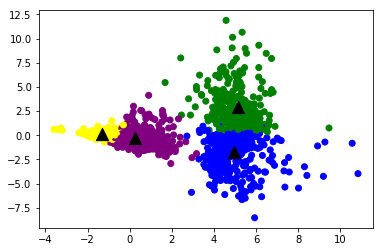

In [13]:
import matplotlib.pyplot as plt
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [14]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for i in range(1000):
        tokens.append(model.docvecs[i])
        labels.append(i)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

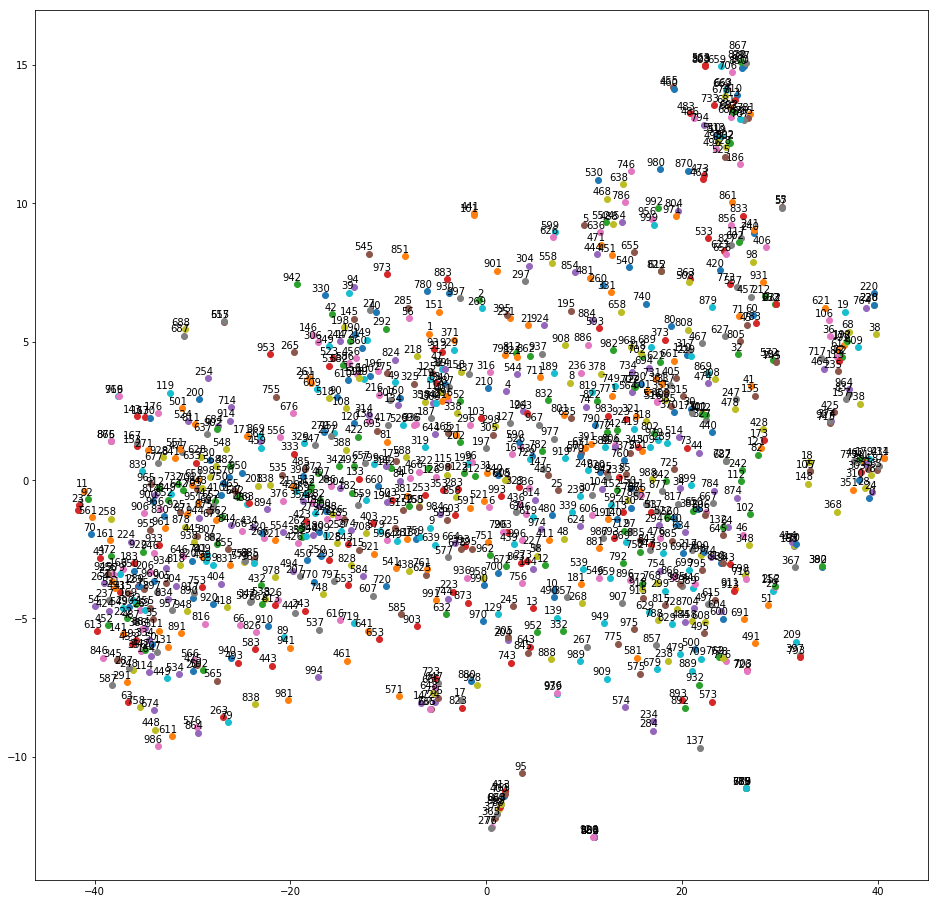

In [16]:
tsne_plot(model)

### using pretrained model by google

In [29]:
model = gensim.models.doc2vec.Doc2Vec.load('./apnews_dbow/doc2vec.bin')

In [32]:
import numpy as np
a = model.infer_vector(contents_['list_contents'][0]).reshape(1,300)
for i in range(1,5363): #5363
    b = model.infer_vector(contents_['list_contents'][i]).reshape(1,300)
    a = np.concatenate((a, b), axis=0)

In [33]:
a.shape

(5363, 300)

In [34]:
Doc2Vec_pretrained = pd.DataFrame(a,columns=['Pre_Doc2Vec_f{}'.format(i) for i in range(1,301)])
Doc2Vec_pretrained.head()

,Pre_Doc2Vec_f1,Pre_Doc2Vec_f2,Pre_Doc2Vec_f3,Pre_Doc2Vec_f4,Pre_Doc2Vec_f5,Pre_Doc2Vec_f6,Pre_Doc2Vec_f7,Pre_Doc2Vec_f8,Pre_Doc2Vec_f9,Pre_Doc2Vec_f10,...,Pre_Doc2Vec_f291,Pre_Doc2Vec_f292,Pre_Doc2Vec_f293,Pre_Doc2Vec_f294,Pre_Doc2Vec_f295,Pre_Doc2Vec_f296,Pre_Doc2Vec_f297,Pre_Doc2Vec_f298,Pre_Doc2Vec_f299,Pre_Doc2Vec_f300
0,-0.344248,-0.347838,-0.175678,-0.079595,-0.048744,-0.038706,-0.267172,-1.008872,-0.057370,-0.325998,...,0.259387,-0.327340,0.412574,0.185464,-0.203760,-0.040312,0.422903,0.091333,0.370502,0.264665
1,-0.006598,0.023259,-0.133878,-0.011773,-0.061570,0.041536,-0.286036,0.081177,-0.181855,-0.016568,...,0.000323,-0.212130,0.113258,0.161091,-0.428033,-0.235717,-0.109161,-0.094630,-0.009641,-0.148301
2,-0.002963,-0.015582,-0.104835,0.143139,0.077515,0.030537,-0.191341,0.255992,-0.029815,-0.026122,...,-0.188861,-0.040794,-0.419064,0.109502,-0.481307,-0.084065,-0.218906,-0.287898,0.072077,0.317852
3,0.118311,-0.069228,-0.264404,0.142889,0.032075,0.149364,-0.095372,0.072506,0.043688,0.096990,...,0.121635,-0.087753,-0.090181,0.095838,-0.351255,-0.146965,0.111908,-0.036933,0.023482,0.074320
4,0.060745,0.077263,-0.517718,-0.257046,0.057317,0.245623,-0.398536,-0.235504,0.191876,0.096845,...,-0.150429,0.127446,-0.013987,-0.258445,-0.574901,-0.199325,-0.569843,0.153968,-0.237232,0.092018


In [35]:
Doc2Vec_pretrained.to_pickle('Doc2Vec_pretrained.pkl')

In [36]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100)  
X = kmeans_model.fit(a)
labels=kmeans_model.labels_.tolist()

In [37]:
from sklearn.decomposition import PCA
l = kmeans_model.fit_predict(a)
pca = PCA(n_components=2).fit(a)
datapoint = pca.transform(a)

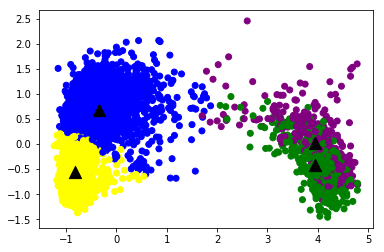

In [38]:
import matplotlib.pyplot as plt
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [39]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for i in range(5363):
        tokens.append(a[i])
        labels.append(i)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

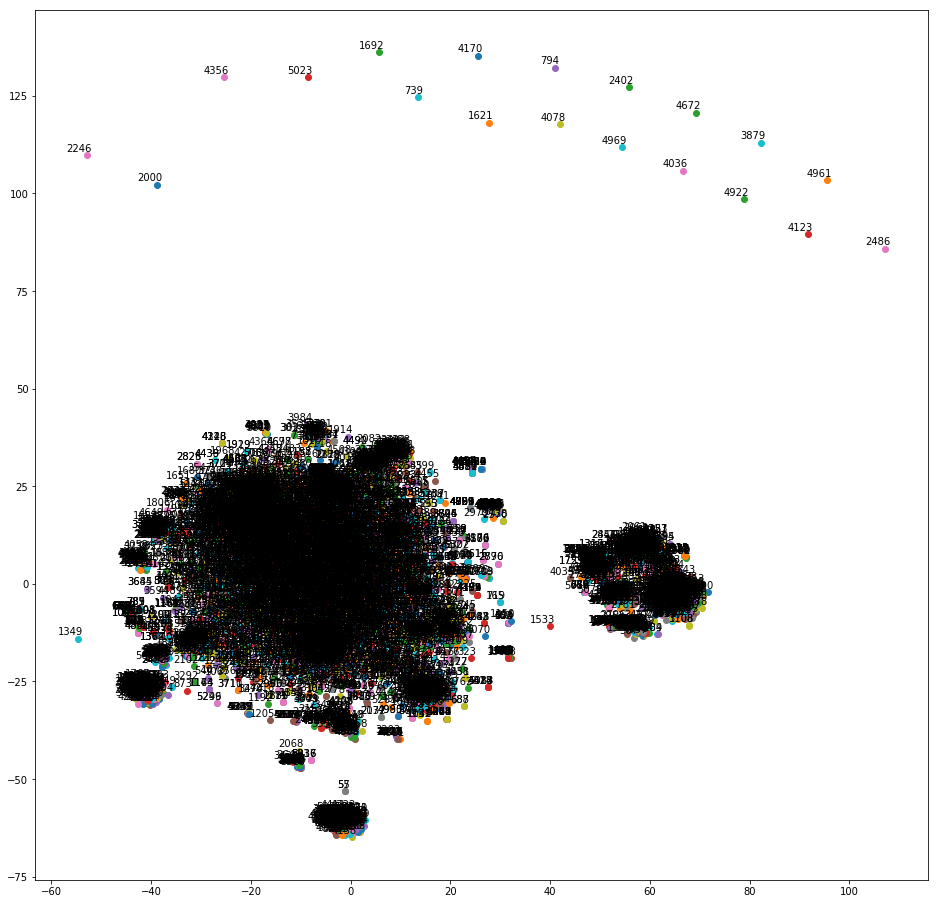

In [49]:
tsne_plot(model)

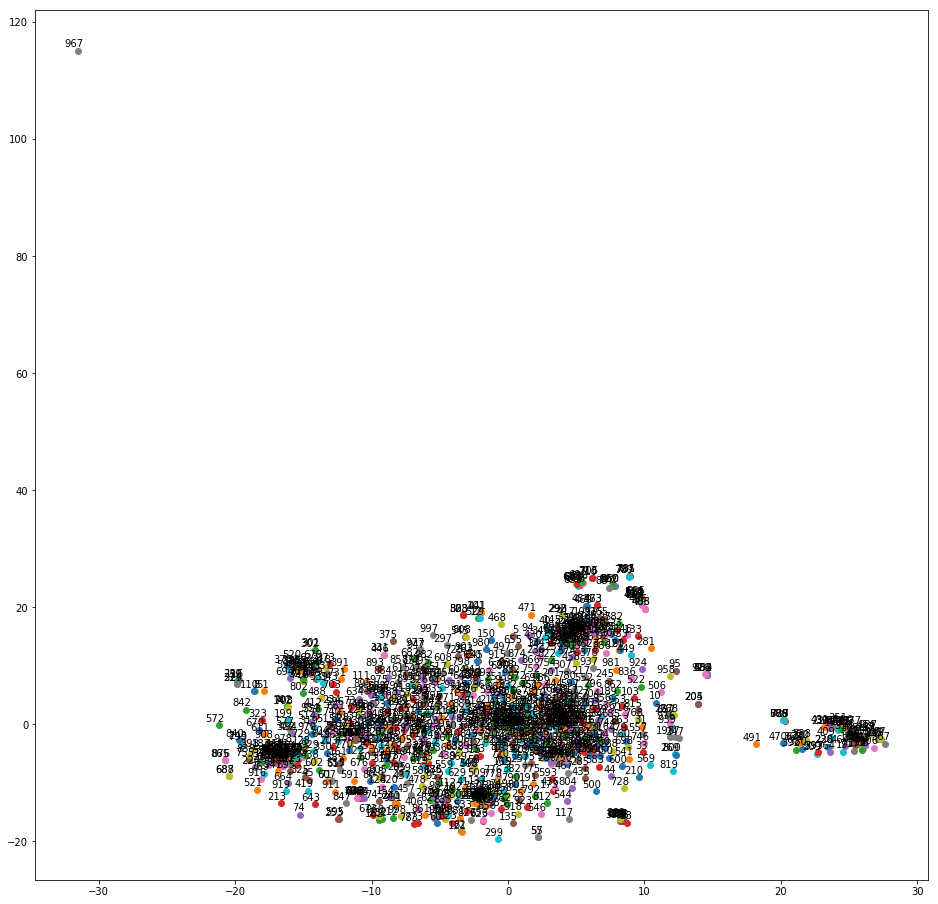

In [45]:
tsne_plot(model)

In [47]:
contents_.iloc[967]

content                Abstract: The strike in the South African pla...
title                        WEEKLY COMMODITIES : South African strikes
date                                                2014-05-08 14:20:00
preprocess_content    abstract strike south african platinum belt ma...
content_pos           1CLFCGGLL6TFSGL3RCIAILFGGLR5GMY1SGLFLALMN2T4FB...
polarity                                                     0.00554299
subjectivity                                                   0.343326
list_contents         [Abstract:, The, strike, in, the, South, Afric...
Name: 967, dtype: object

## Title_vec

In [58]:
titles = pd.read_pickle('preprocess_title.pkl')

In [59]:
titles.head()

,title_to_handle,preprocess_title
0,[Delayed] Global Oil & Gas Daily: Egypt to off...,global oil gas egypt offer block bidding cvx-y...
1,Commodity Daily Market Watch,commodity market watch
2,Commodity Daily Report 1st Jan 2013,commodity 1st
3,"Bullion, Base metals& Energy Report",bullion base metal energy
4,"Energy insight- Jan 02, 2013",energy insight-
